In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from tqdm import tqdm
sys.path.append('..')
import analysis.result as r
from utils.persistent_data_class import ExpData, ImageDataset

In [2]:
project_path = '/home/avic/OOD_Orientation_Generalization/'
storage_path = '/home/avic/om2/OODOG/'

In [3]:
exps = pd.read_csv(os.path.join(project_path, 'exps.csv'))

In [13]:
ID = ImageDataset('/home/avic/om2/OODOG/', 'plane', 32)

In [17]:
ID.subdatasets[0].annotation_file.df

RangeIndex(start=0, stop=32775, step=1)

In [27]:
from PIL import Image

In [61]:
heatmap = Result.from_exp_data(ExpData.from_num(project_path, storage_path, 0, 20, 0), project_path).partial_heatmap.arr.mean(axis=2)

In [65]:
(16 * 164) / 32

82.0

In [69]:
expanded_heatmap = np.broadcast_to(heatmap[:, np.newaxis, :, np.newaxis], (32, 82, 32, 82)).reshape(32 * 82, 32 * 82)

In [52]:
images = np.stack([np.array(Image.open(p).crop((30, 30, 224-30, 224-30))) for p in ID.subdatasets[0].annotation_file.df.iloc[selections].image_name])

In [88]:
airplane_grid = np.moveaxis(images.reshape(16, 16, 164, 164), 1, 2).reshape(16 * 164, 16 * 164).astype(float)
airplane_grid[airplane_grid == 0] = np.nan

In [ ]:
plt.close()
_, a = plt.subplots(1, figsize=(50, 50))
a.imshow(expanded_heatmap)
a.imshow(airplane_grid, cmap='gray')

In [10]:
convert_axis_to_int = {'α': 3, 'β': 2, 'γ': 1, 'hole': 3}

In [33]:
from matplotlib.colors import ListedColormap
ListedColormap([[0,0,0,0], [1,0,0,0.5]])

In [ ]:
l = [[None, None]] * 4
for i, row in enumerate(exps[(exps.full_category == 'plane') & (exps.partial_category == 'plane') & (exps.free_axis == 'α')].itertuples()):
    l[i][0] = np.stack([np.stack([Result.from_exp_data(ExpData.from_num(project_path, storage_path, row.Index, num_fully_seen, run), project_path).partial_heatmap.arr for run in range(5)]) for num_fully_seen in [10, 20, 30, 40]]).mean(axis=convert_axis_to_int[row.free_axis] + 1)
    l[i][1] = np.stack([np.stack([Result.from_exp_data(ExpData.from_num(project_path, storage_path, row.Index, num_fully_seen, run), project_path).base_mask.arr for run in range(5)]) for num_fully_seen in [10, 20, 30, 40]]).mean(axis=convert_axis_to_int[row.free_axis] + 1)

In [ ]:
plt.close()
_, axes = plt.subplots(2, 4, figsize=(30, 30))
for x in range(1):
    for y in range(4):
        plt.imshow(l[x][0][y].mean(axis=0), vmin=0, vmax=1)
        plt.imshow(l[x][1][y].mean(axis=0), vmin=0, vmax=1, cmap=ListedColormap([[0,0,0,0], [1,0,0,0.5]]))
        axes[x, y].set_xticks([])
        axes[x, y].set_yticks([])
plt.tight_layout()

In [4]:
import importlib
# import shutil

In [5]:
importlib.reload(r)
Result = r.Result

In [8]:
results = []
exp_datas = []
idxs = {}

for idx in tqdm(exps[:22].index):
    for job_i in range(idx * 20, (idx + 1) * 20):
        idxs[(idx, job_i)] = len(results)
        exp_data = ExpData.from_job_i(project_path, storage_path, job_i)
        exp_datas.append(exp_data)
        results.append(Result.from_job_i(project_path, storage_path, job_i))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:13<00:00,  1.59it/s]


In [9]:
accuracy_frame = pd.concat([result.accuracy_frame for result in results]).reset_index(drop=True)
correlation_frame = pd.concat([result.correlation_frame for result in results]).reset_index(drop=True)
selectivity_frame = pd.concat([result.selectivity_frame for result in results]).reset_index(drop=True)
invariances_frame = pd.concat([result.invariances_frame for result in results]).reset_index(drop=True)

In [15]:
sns.set_context("paper")

/tmp/ipykernel_44744/2562773498.py:1: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(kind='line',


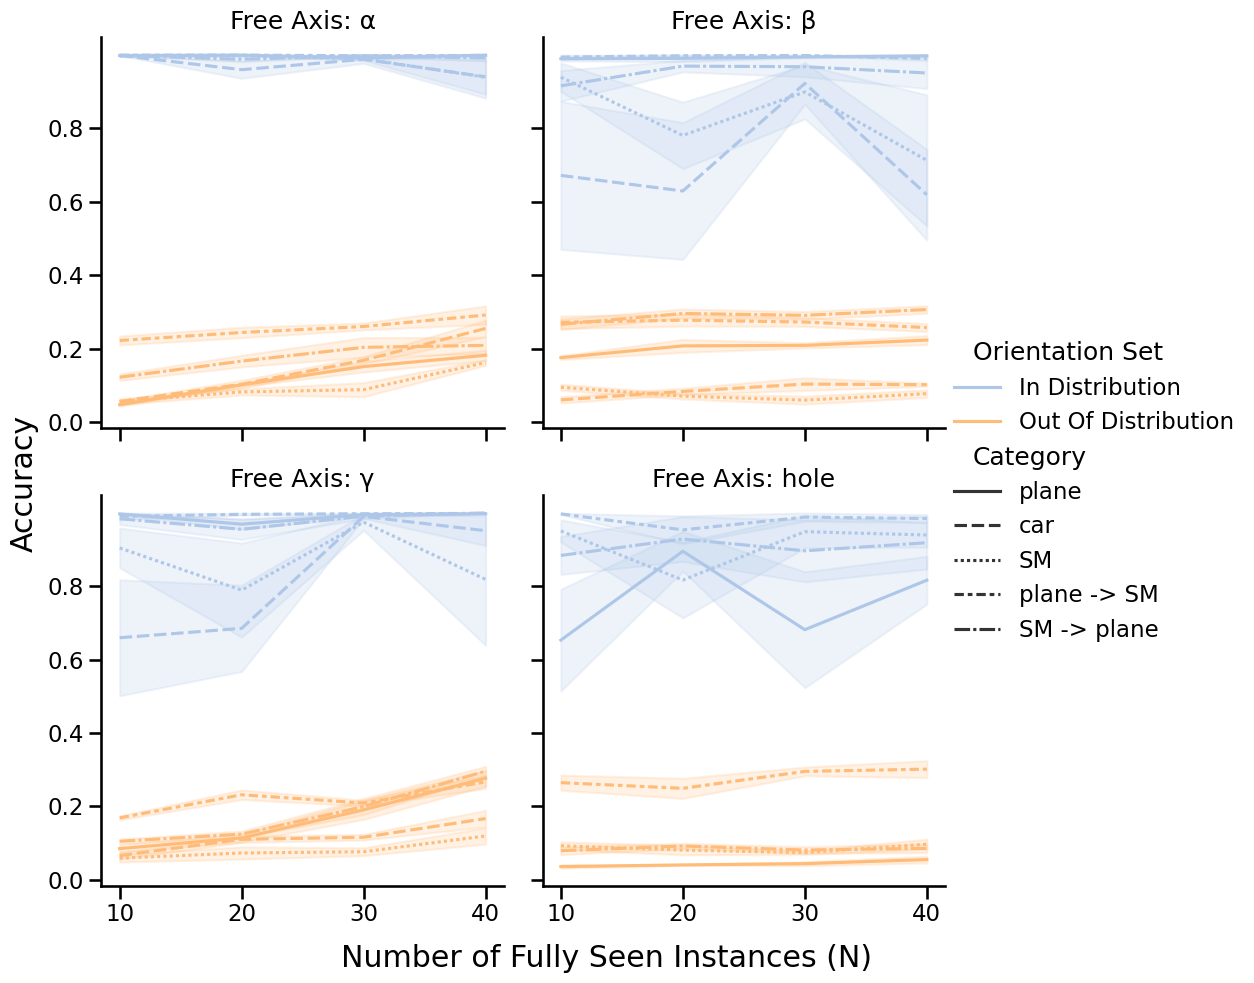

In [14]:
g = sns.relplot(kind='line',
            data=id_ood_accuracy_frame, 
            x='Instances Fully Seen', 
            y='Accuracy', 
            hue='Orientation Set', 
            col='Free Axis', 
            style='Category',
            style_order=['plane', 'car', 'SM', 'plane -> SM', 'SM -> plane'],
            errorbar='se',
            col_wrap=2,
            palette=sns.color_palette('tab20')[1::2])

# g.set_titles('{row_name}, {col_name}')
plt.setp(g.axes.flat, xlabel='', ylabel='', xticks=range(10,50,10), yticks=[0.2 * i for i in range(5)])
g.set_titles(row_template = '{row_name}', col_template = 'Free Axis: {col_name}')
g.fig.supxlabel("Number of Fully Seen Instances (N)")
# g.fig.supylabel("Pearson Correlation (ρ)", x=0.05)
g.fig.supylabel("Accuracy", x=0.04)
plt.savefig('dist_acc.png', transparent=True)

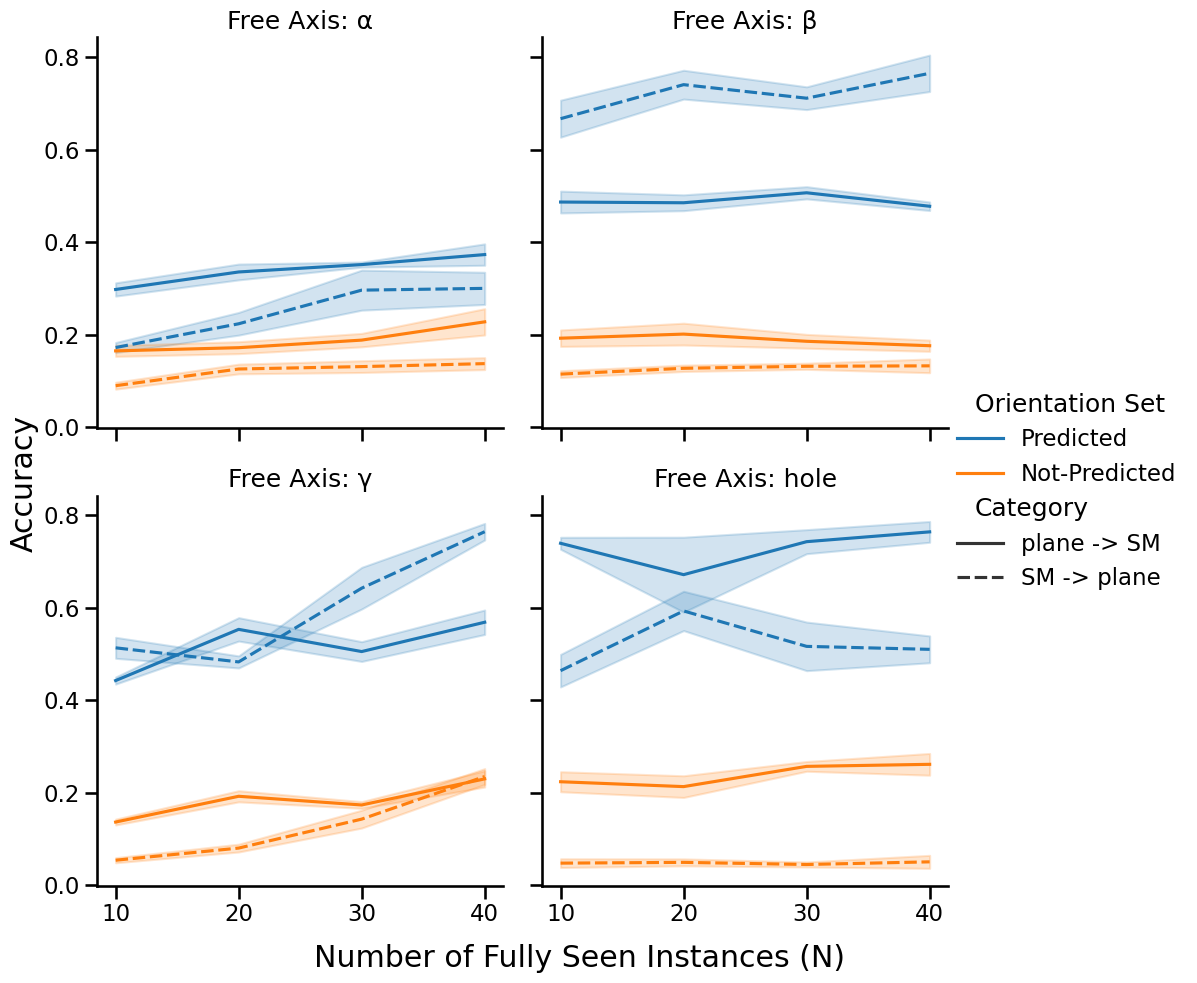

In [32]:
g = sns.relplot(kind='line',
            data=accuracy_frame, 
            x='Instances Fully Seen', 
            y='Accuracy', 
            hue='Orientation Set', 
            col='Free Axis', 
            style='Category',
            # style_order=['plane', 'car', 'SM'],
            style_order=['plane -> SM', 'SM -> plane'],
            errorbar='se',
            col_wrap=2)

# g.set_titles('{row_name}, {col_name}')
plt.setp(g.axes.flat, xlabel='', ylabel='', xticks=range(10,50,10), yticks=[0.2 * i for i in range(5)])
g.set_titles(row_template = '{row_name}', col_template = 'Free Axis: {col_name}')
g.fig.supxlabel("Number of Fully Seen Instances (N)")
# g.fig.supylabel("Pearson Correlation (ρ)", x=0.05)
g.fig.supylabel("Accuracy", x=0.04)
plt.savefig('dist_acc.png', transparent=True)

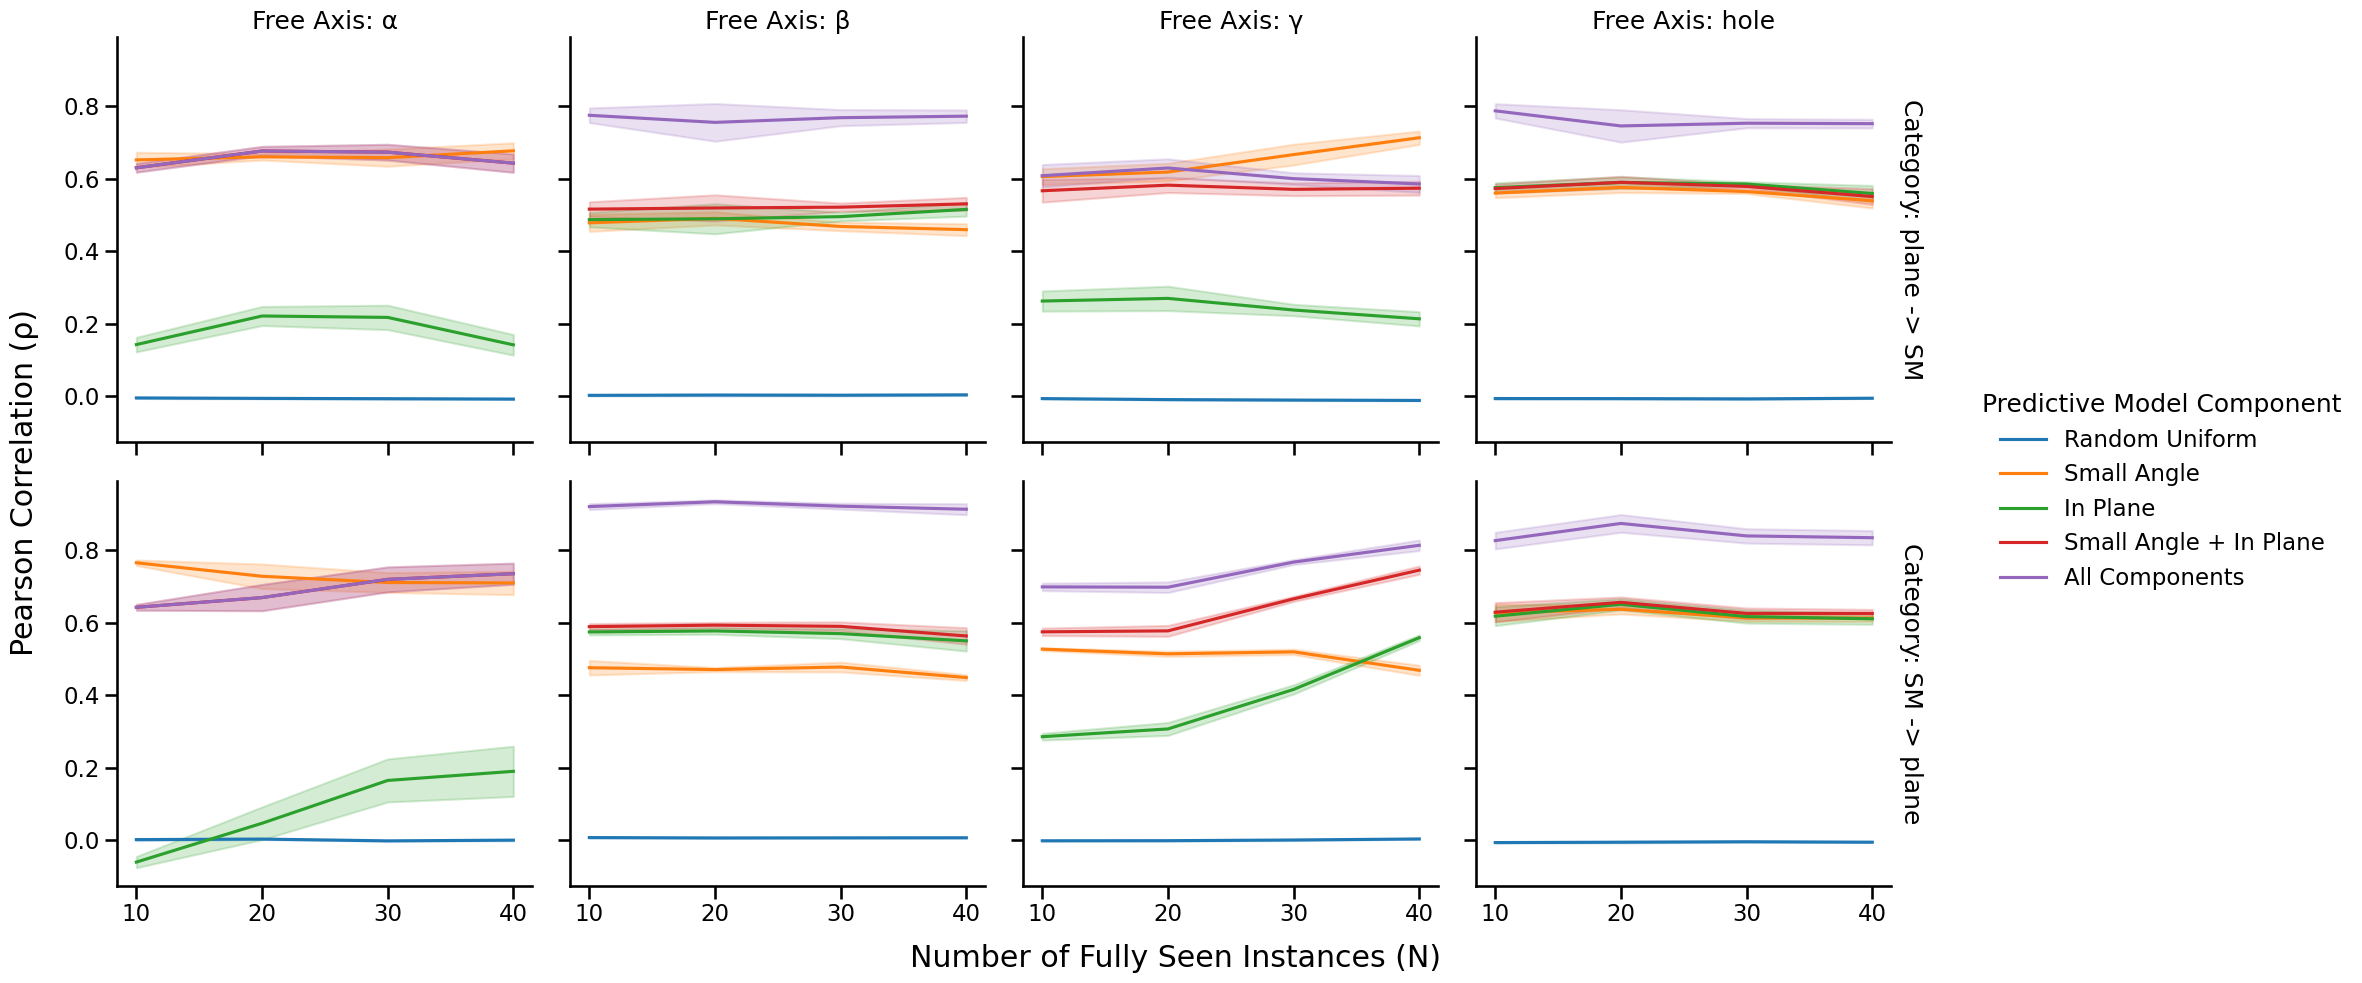

In [33]:
g = sns.relplot(kind='line',
            data=correlation_frame,
            x='Instances Fully Seen', 
            y='Correlation', 
            hue='Predictive Model Component',
            col='Free Axis', 
            row='Category', 
            row_order=['plane -> SM', 'SM -> plane'],
            errorbar='se',
            facet_kws={'margin_titles':True})

# g = sns.FacetGrid(correlation_frame, 
#                   hue='Predictive Model Component', 
#                     col='Free Axis', 
#                     row='Category',
#                   margin_titles=True,
#                  palette=sns.color_palette('tab10')[5:])

# g.map(sns.lineplot, 'Instances Fully Seen', 'Correlation')

# g.set_titles('{row_name}, {col_name}')
[plt.setp(ax.texts, text='') for ax in g.axes.flat]
plt.setp(g.axes.flat, xlabel='', ylabel='', xticks=range(10,50,10), yticks=[0.2 * i for i in range(5)])
g.fig.supxlabel("Number of Fully Seen Instances (N)")
g.fig.supylabel("Pearson Correlation (ρ)", x=0.01)
g.set_titles(row_template = 'Category: {row_name}', col_template = 'Free Axis: {col_name}')
plt.savefig('dist_acc.png', transparent=True)

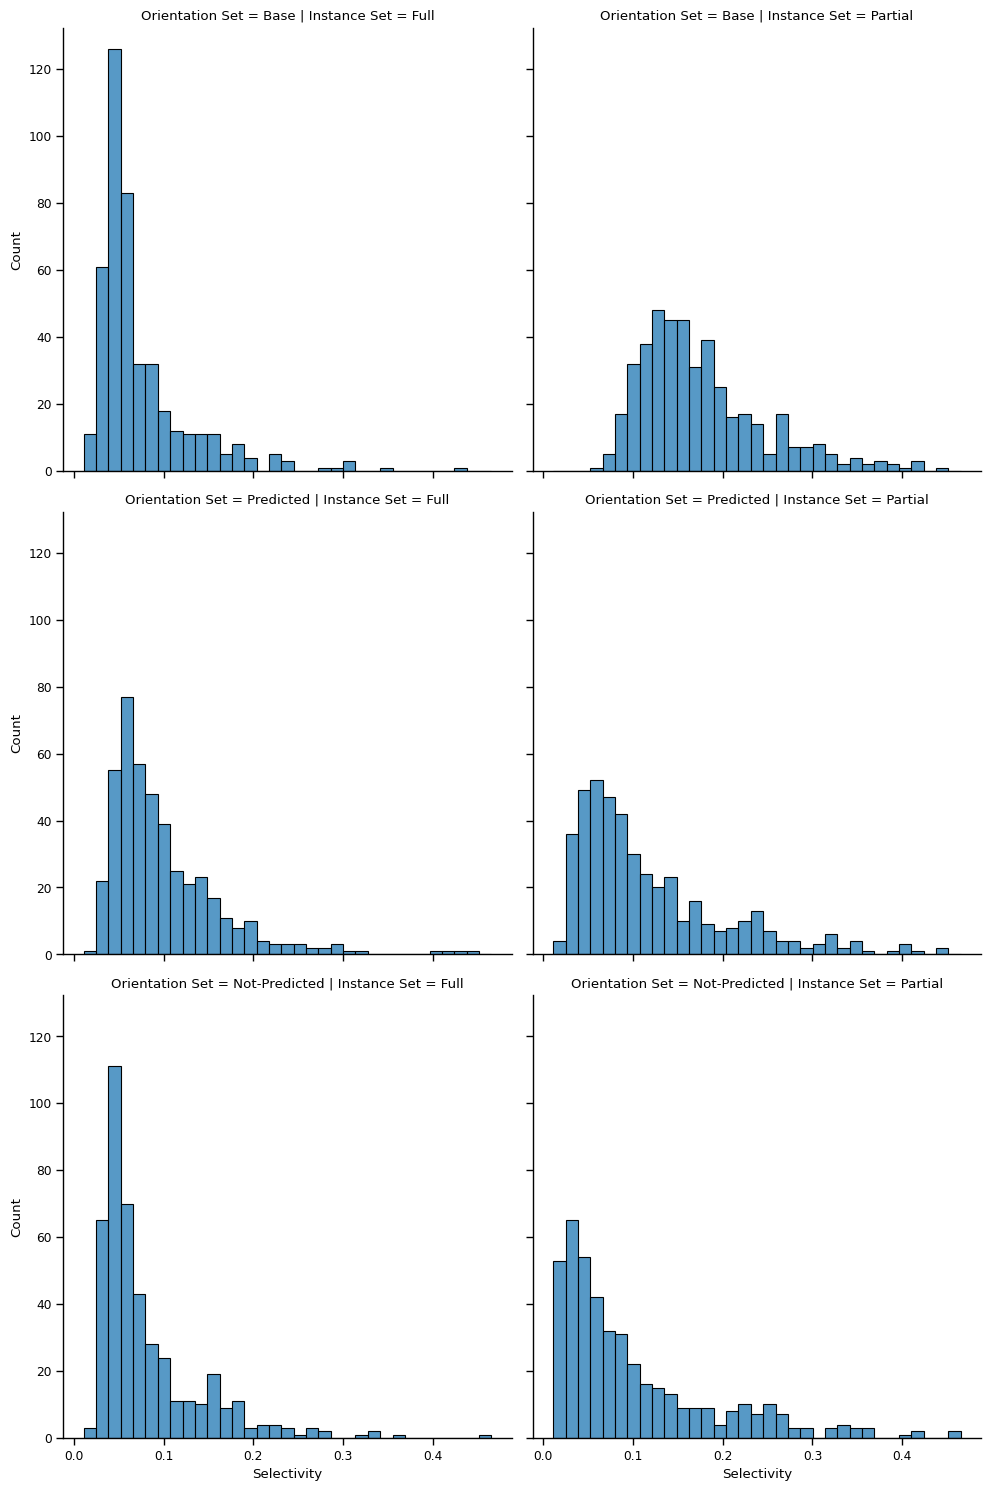

In [16]:
g = sns.displot(data=selectivity_frame,
       x='Selectivity',
                row='Orientation Set',
       col='Instance Set',
               multiple='stack')
plt.savefig('selectivity.pdf', transparent=True)

In [74]:
a = invariances_frame[(invariances_frame['Instance Transform'] == 'Partial -> Partial') & (invariances_frame['Orientation Transform'] != 'Predicted -> Not-Predicted')].copy()

In [75]:
a['Orientation Set'] = a['Orientation Transform'].apply(lambda t: t[8:])

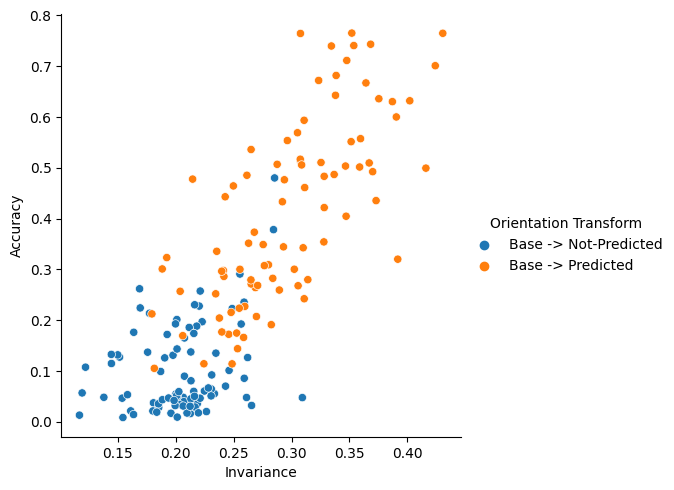

In [76]:
g = sns.relplot(kind='scatter',
            data=accuracy_frame.merge(a).groupby(['Orientation Set', 'Instances Fully Seen',
       'Free Axis', 'Category', 'Instance Transform', 'Orientation Transform']).mean().reset_index(),
            x='Invariance',
            y='Accuracy',
            # col_order=['plane', 'car', 'SM', 'plane -> SM', 'SM -> plane'],
            hue='Orientation Transform',
            # col_wrap=3,
            # col='Free Axis
           )
# plt.setp(g.axes.flat, xlabel='')
# g.fig.supxlabel("Orientation Invariance for Partially Seen")
# plt.savefig('dist_acc.png', transparent=True, dpi=300)

In [155]:
a = invariances_frame.groupby(['Instace Set', 
                               'Orientation Set', 
                               'Instances Fully Seen', 
                               'Free Axis', 
                               'Category'], sort=False).mean().reset_index()
b = a.pivot(index=['Instace Set', 
                   'Instances Fully Seen',
                   'Free Axis', 
                   'Category'], columns='Orientation Set', values='Invariance').reset_index()
c = b.melt(['Instace Set', 
            'Instances Fully Seen',  
            'Free Axis', 
            'Category',
            'Base -> Base'], 
           ['Base -> Not-Predicted', 
            'Base -> Predicted',
            'Not-Predicted -> Not-Predicted',
            'Not-Predicted -> Predicted',
            'Predicted -> Not-Predicted',
            'Predicted -> Predicted'])

d = c.astype({'Instances Fully Seen': 'category'})

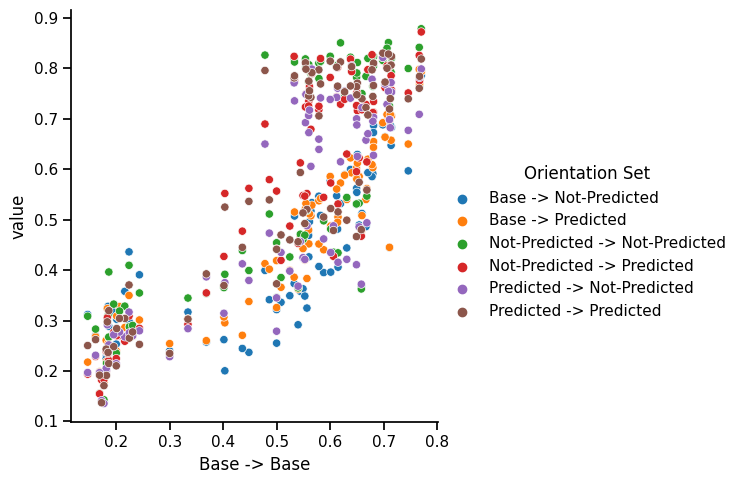

In [166]:
g = sns.relplot(kind='scatter',
            data=d,
            # hue='Base -> Base',
            y='value',
            hue='Orientation Set',
            x='Base -> Base'
           )
# plt.setp(g.axes.flat, xlabel='')
# g.fig.supxlabel("Orientation Invariance for Partially Seen")
# plt.savefig('dist_acc.png', transparent=True, dpi=300)

In [ ]:
g = sns.relplot(kind='scatter',
            data=invariances_frame.groupby(['Instace Set', 'Orientation Set', 'Instances Fully Seen', 'Free Axis', 'Category'], sort=False).mean().reset_index().pivot(index=['Orientation Set', 'Instances Fully Seen',
       'Run', 'Free Axis', 'Category'], columns='Instace Set', values='Invariance').reset_index(),
            x='Base -> Predicted',
            y='Base -> Not-Predicted',
            col='Orientation Set',
            col_order=['Base -> Predicted', 'Base -> Not-Predicted', 'Predicted -> Not-Predicted']
            # col='Free Axis
           )
# plt.setp(g.axes.flat, xlabel='')
# g.fig.supxlabel("Orientation Invariance for Partially Seen")
# plt.savefig('dist_acc.png', transparent=True, dpi=300)

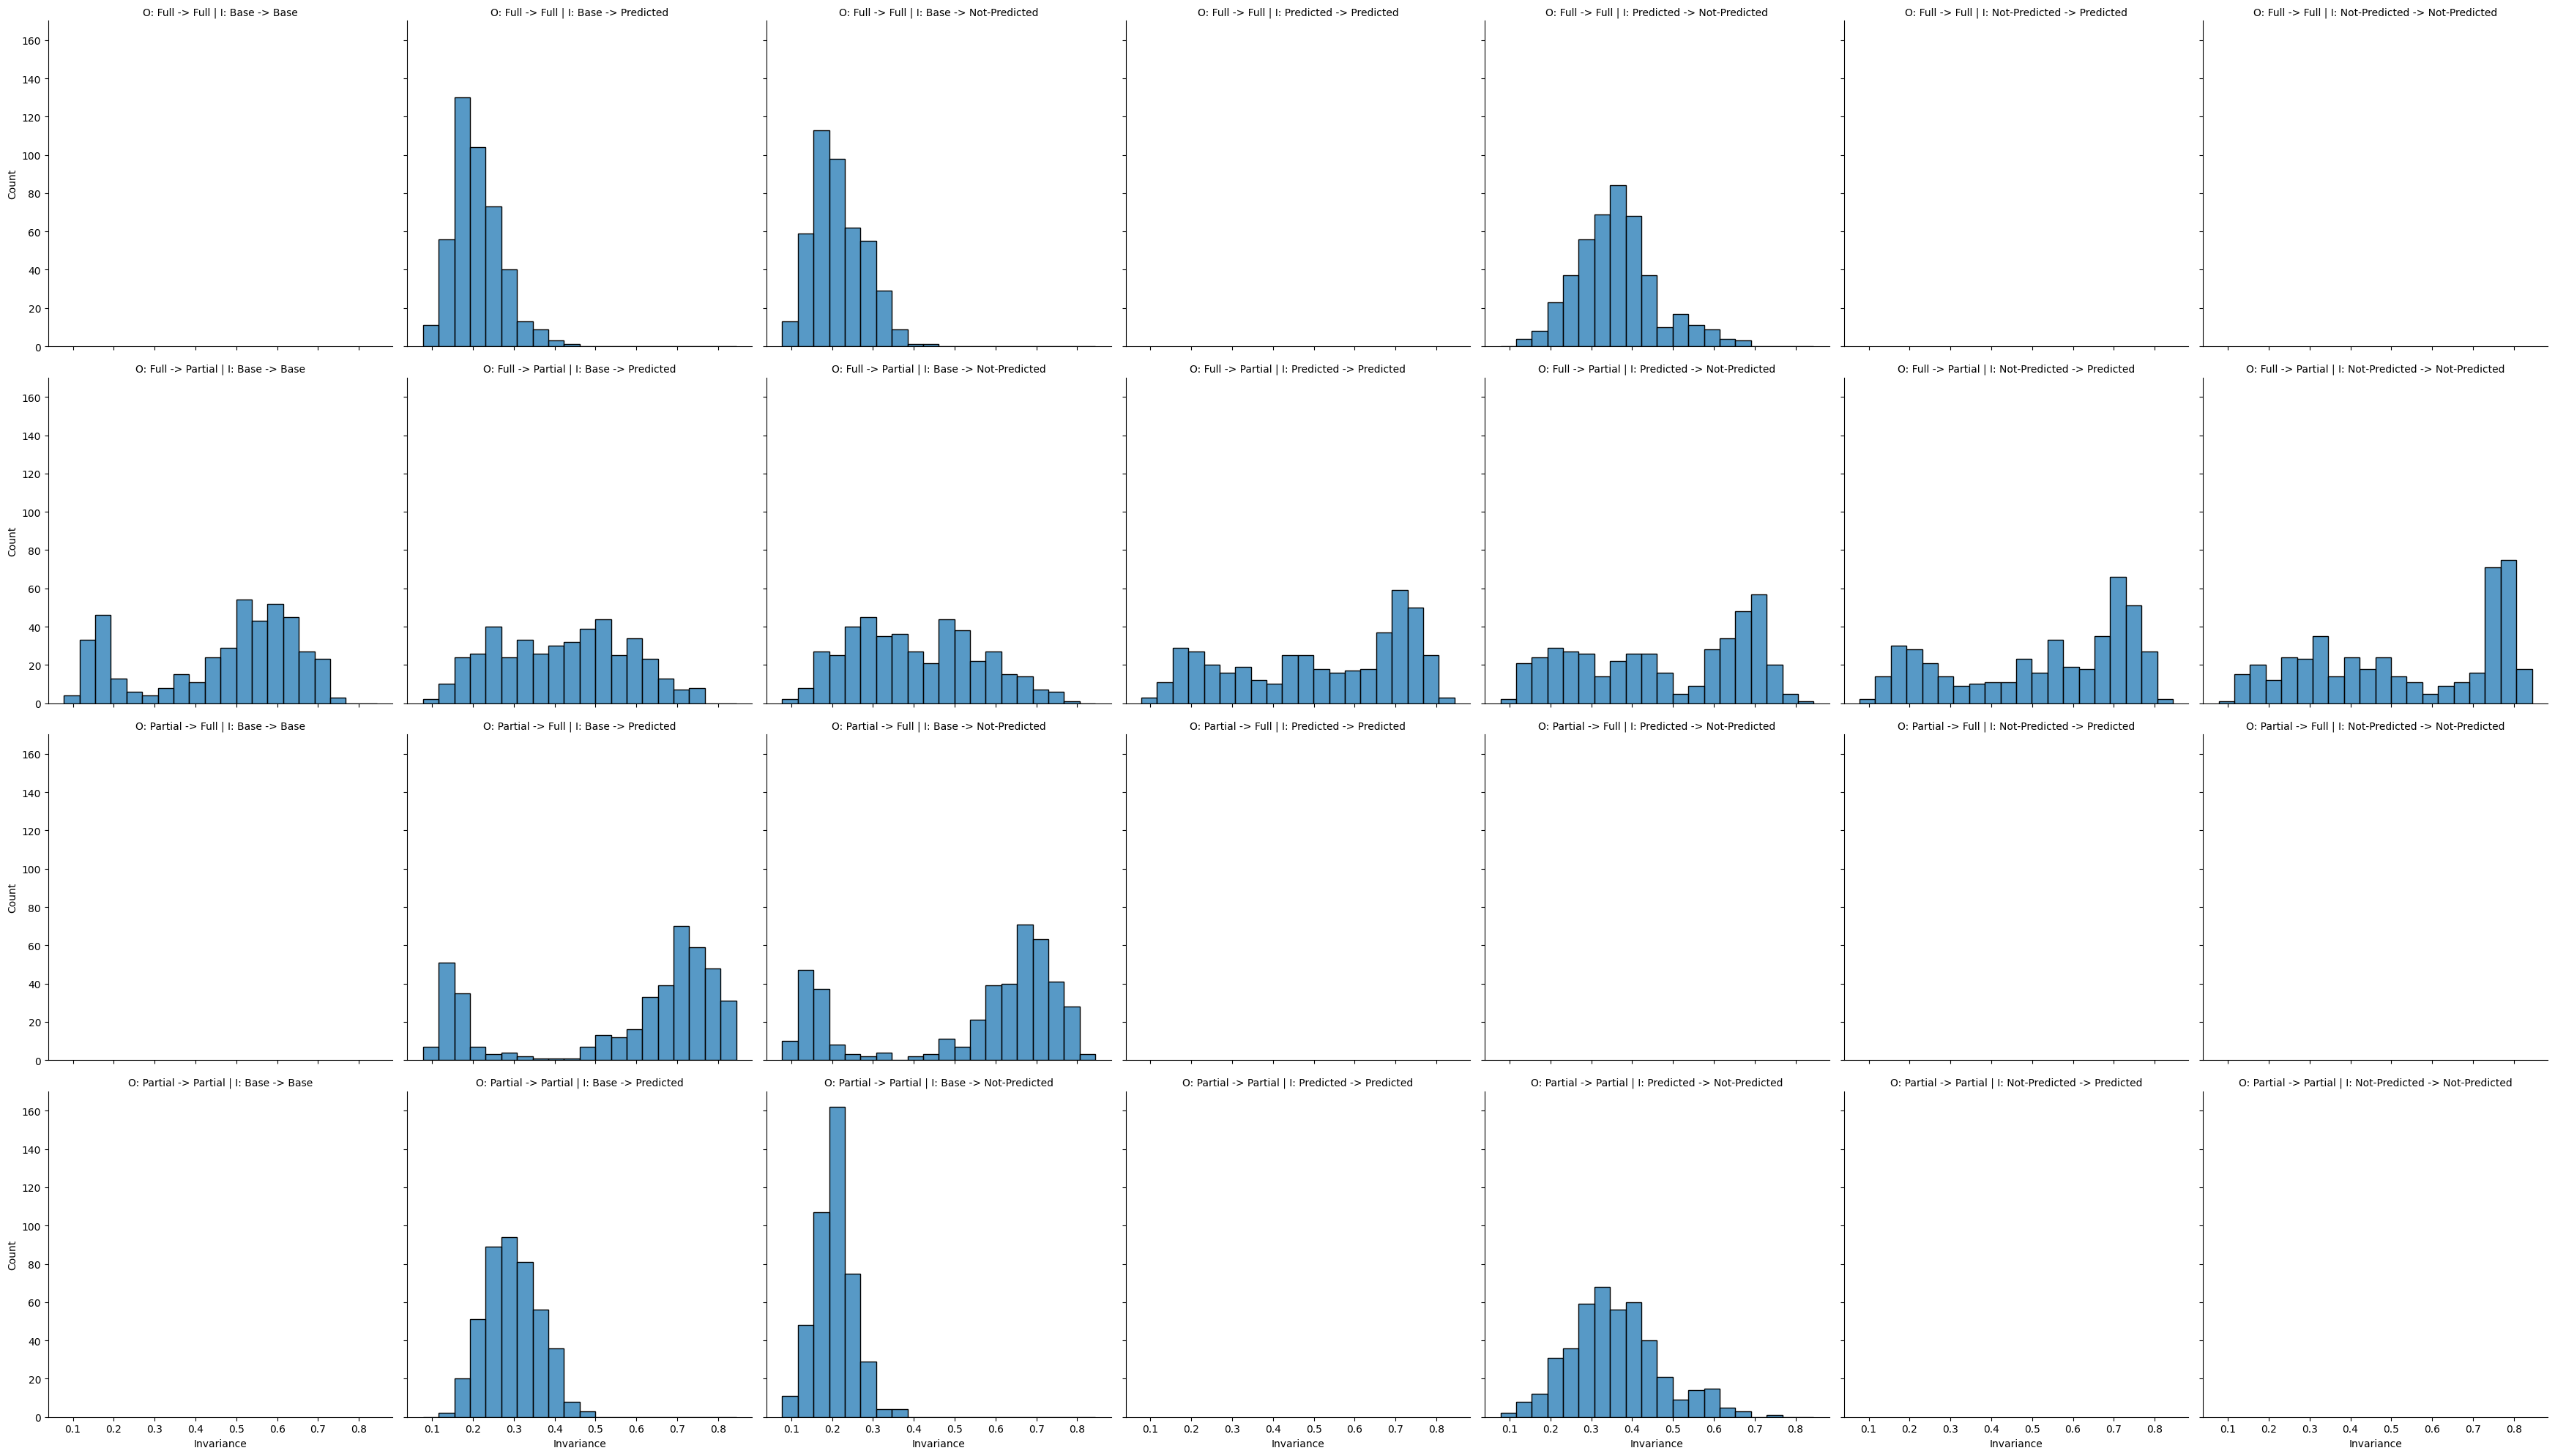

In [78]:
g = sns.displot(data=invariances_frame,
            x='Invariance',
            row='Instance Transform',
            row_order=['Full -> Full', 'Full -> Partial', 'Partial -> Full', 'Partial -> Partial'],
            col='Orientation Transform',
                col_order=['Base -> Base', 'Base -> Predicted', 'Base -> Not-Predicted',
       'Predicted -> Predicted', 'Predicted -> Not-Predicted',
       'Not-Predicted -> Predicted', 'Not-Predicted -> Not-Predicted']
            # col='Free Axis
           )
g.set_titles(row_template = 'O: {row_name}', col_template = 'I: {col_name}')
# plt.setp(g.axes.flat, xlabel='')
# g.fig.supxlabel("Orientation Invariance for Partially Seen")
# plt.savefig('dist_acc.png', transparent=True, dpi=300)

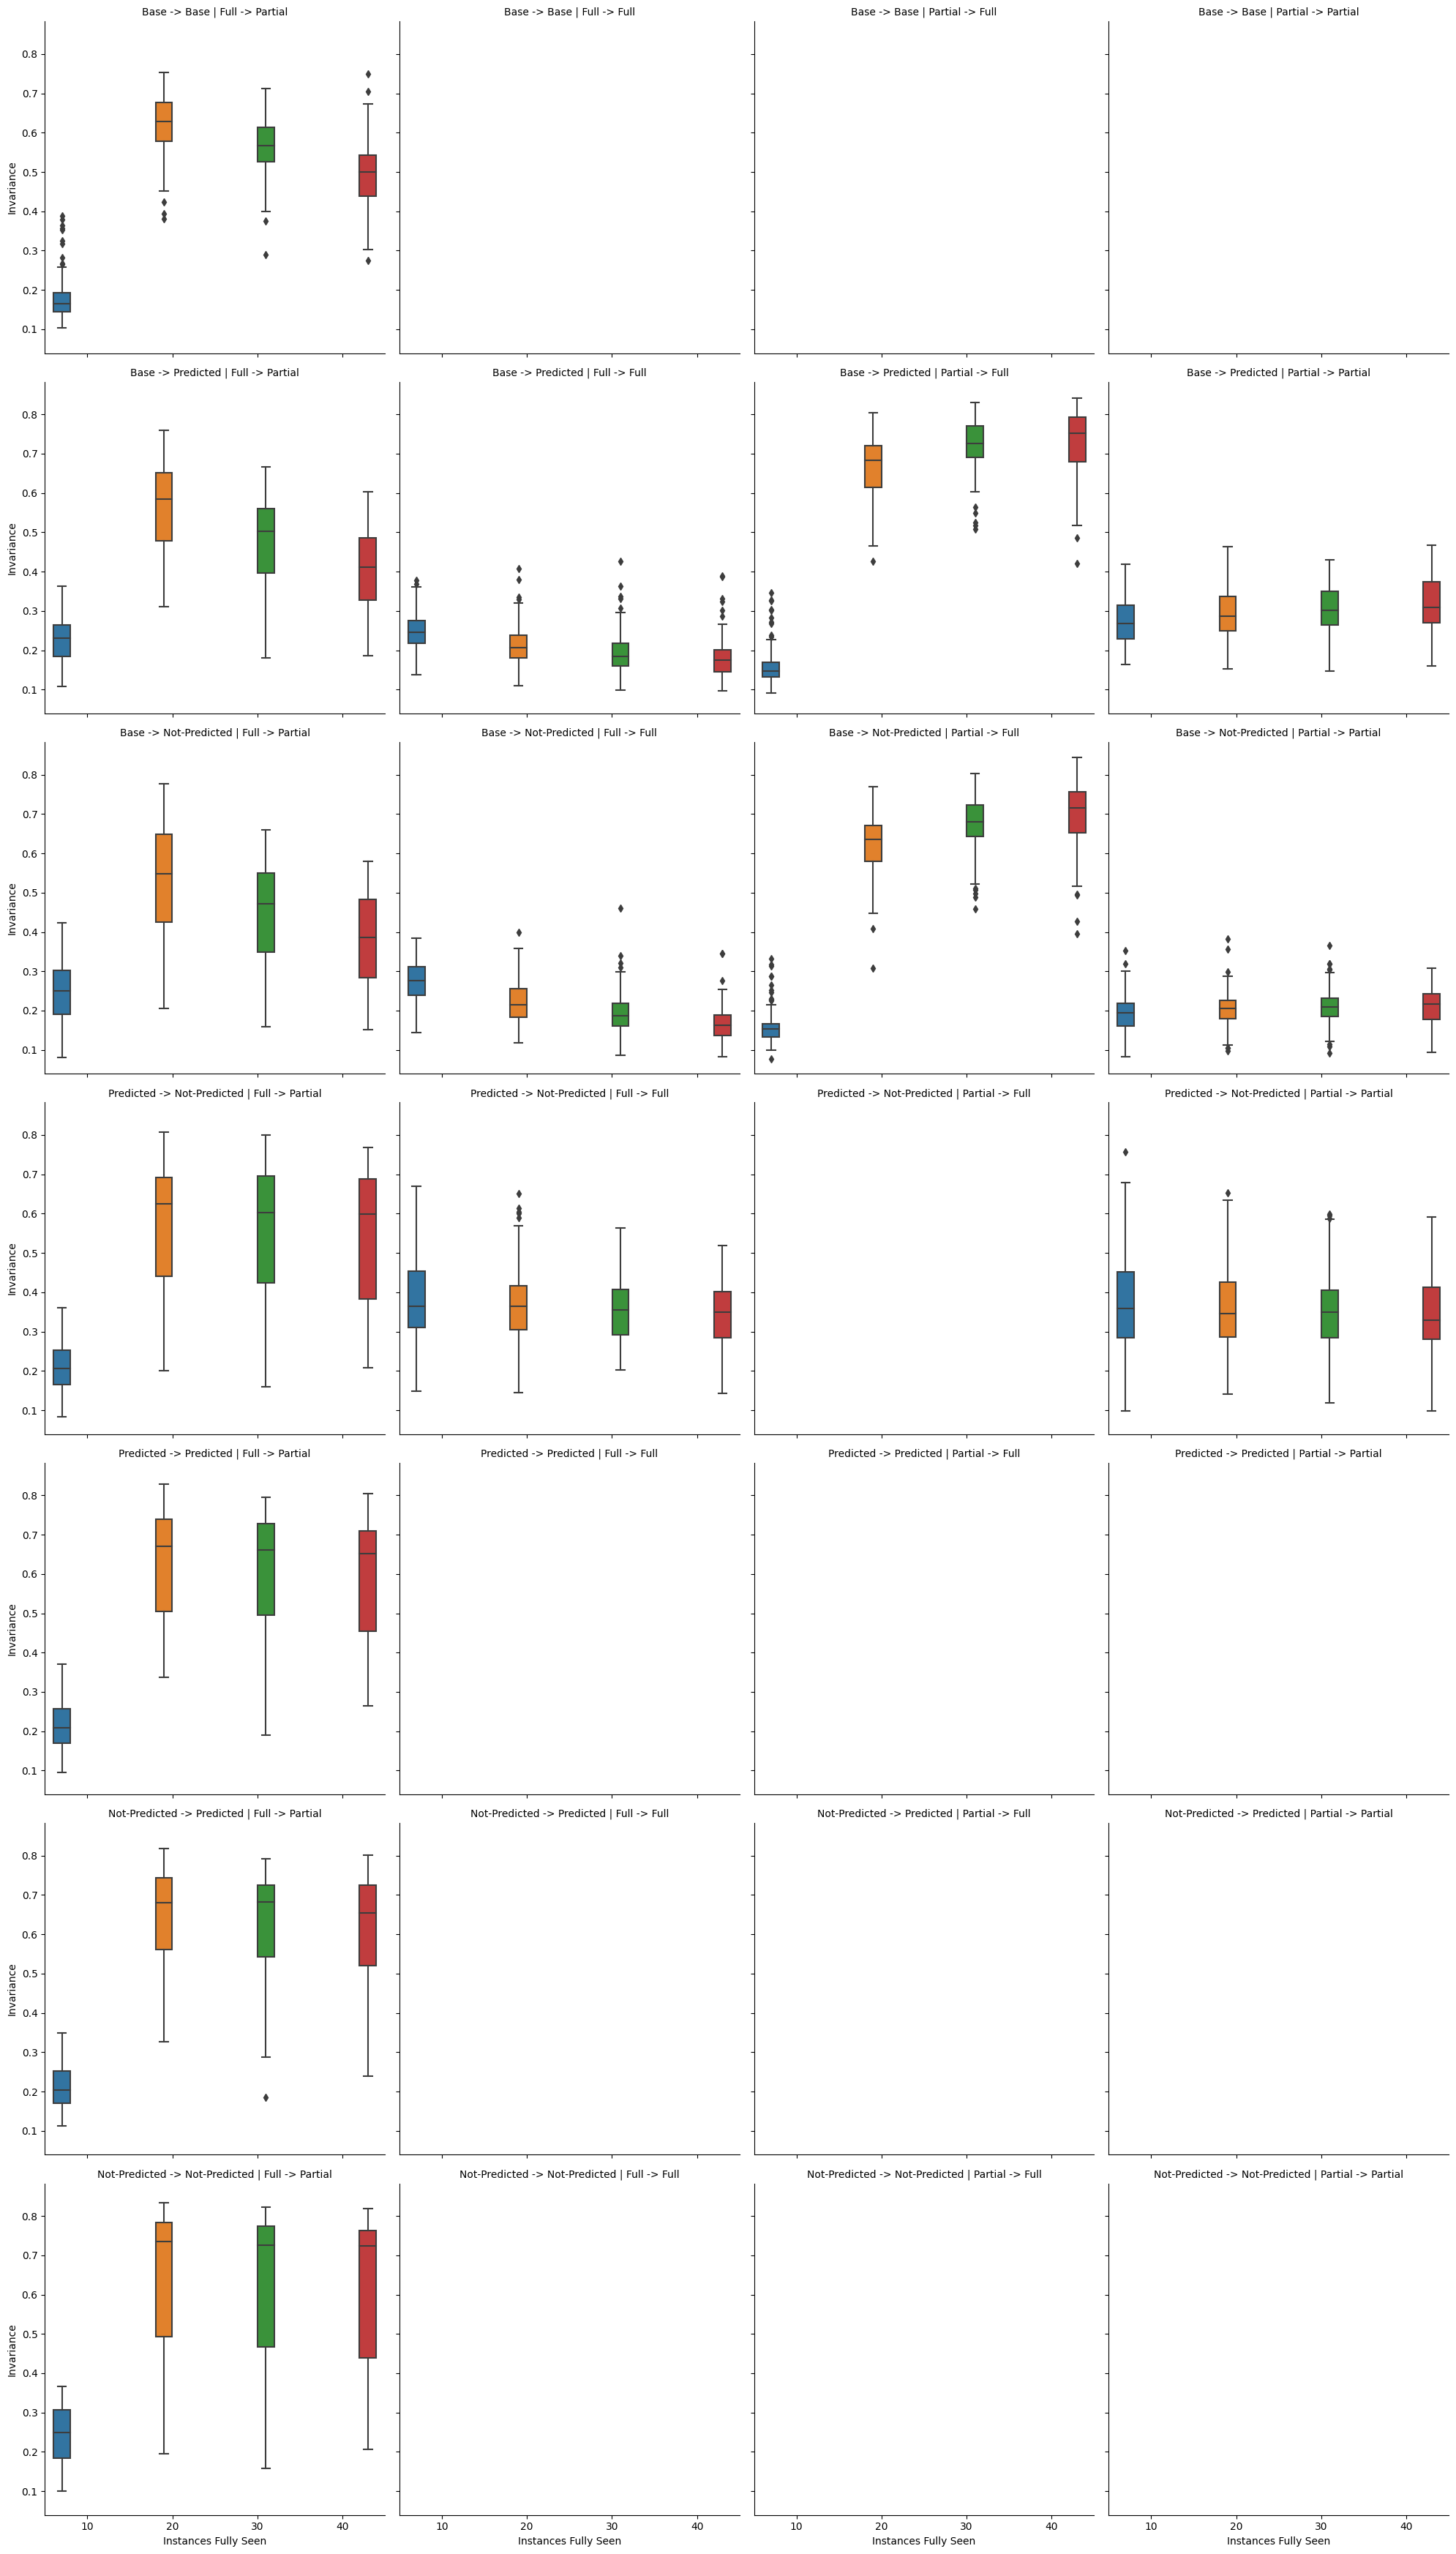

In [79]:
g = sns.catplot(kind='box',
            data=invariances_frame,
            hue='Instances Fully Seen',
            col='Instance Transform',
            row='Orientation Transform',
            x='Instances Fully Seen',
           y='Invariance')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

In [14]:
a = invariances_frame.melt(['Instances Fully Seen', 'Run', 'Free Axis', 'Category'], ['fb_fp', 'fb_fn', 'pb_pp', 'pb_pn'])

In [15]:
a['Instance Set'] = a.variable.apply(lambda v: 'Fully Seen' if v[0] == 'f' else 'Partially Seen')
a['Orientation Set'] = a.variable.apply(lambda v: 'Predicted' if v[-1] == 'p' else 'Not Predicted')

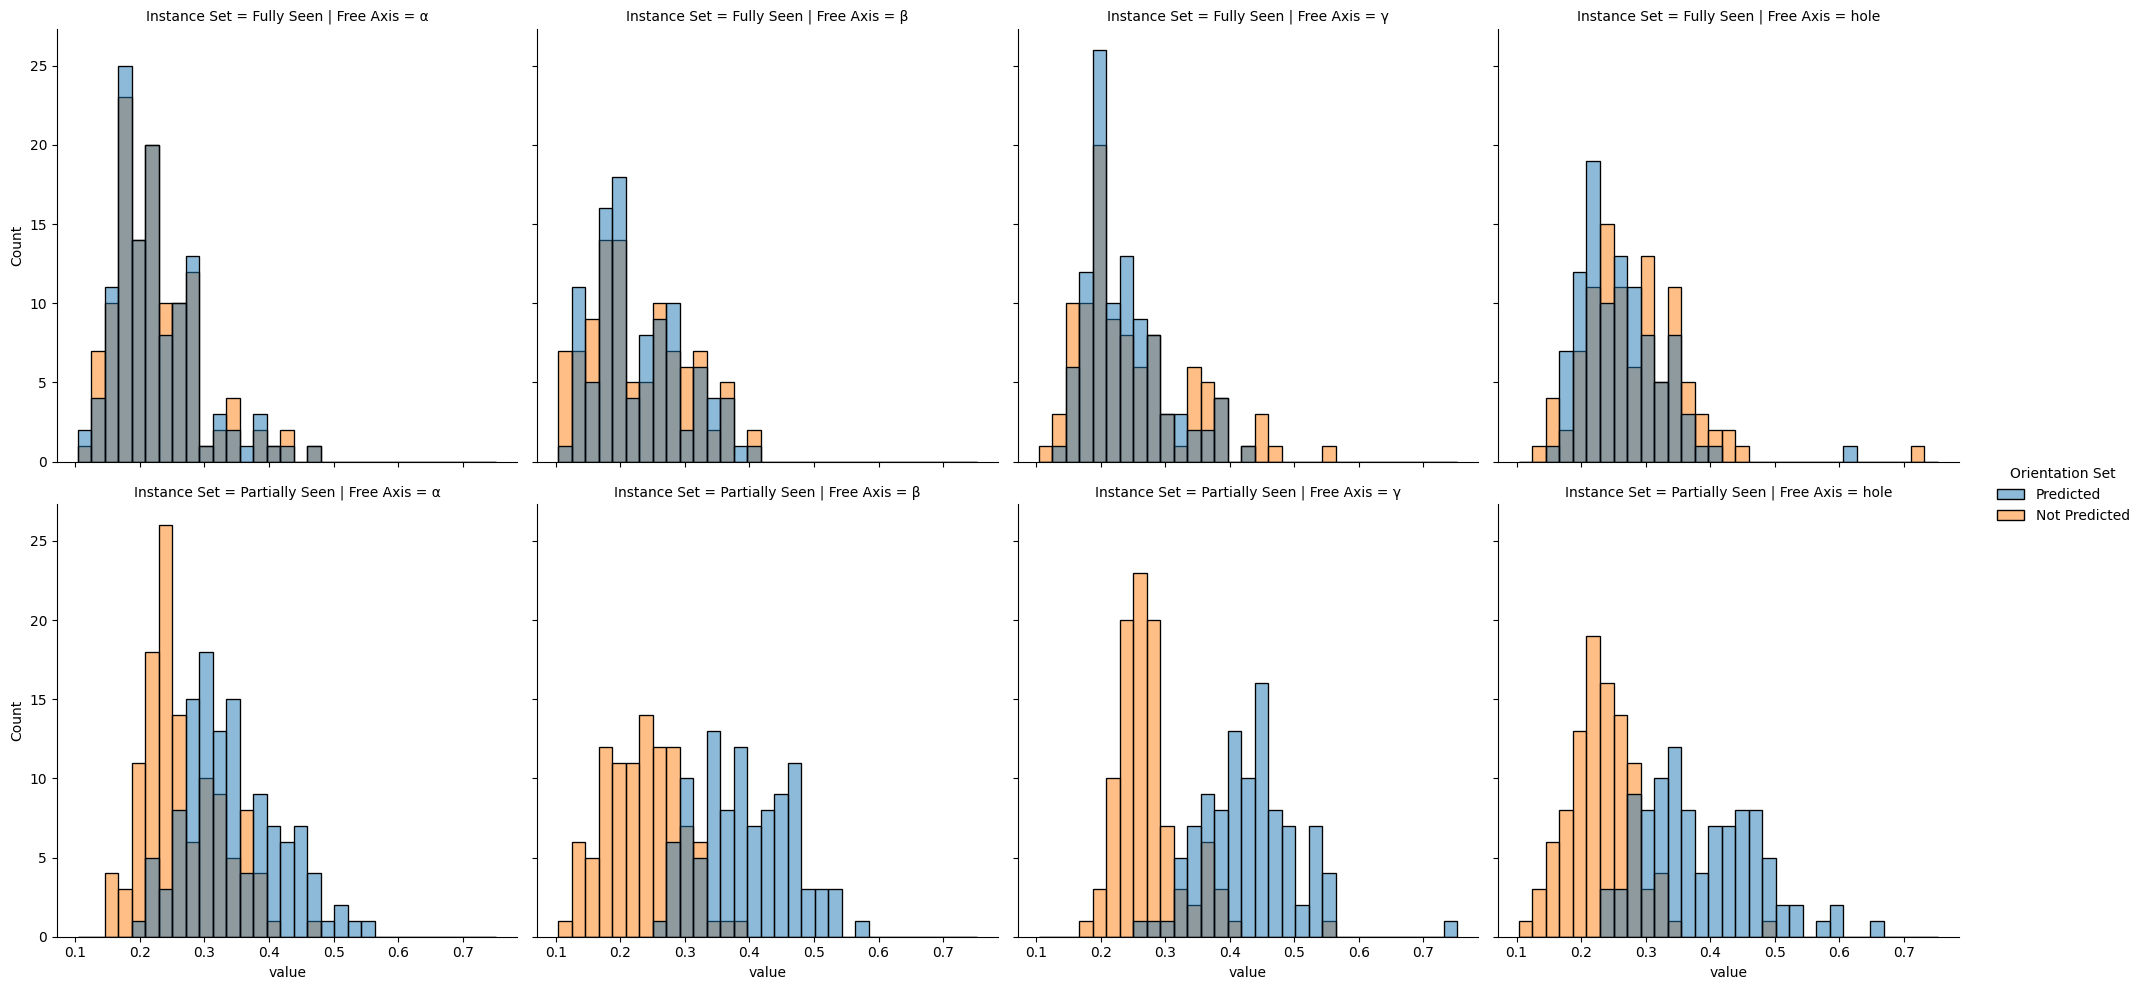

In [16]:
sns.displot(data=a,
           x='value',
           hue='Orientation Set',
           row='Instance Set',
           col='Free Axis')

In [18]:
def dist_mat(arr):
    mat = np.zeros((6, 6))
    triu_indices = np.triu_indices(6, k=1)
    mat[triu_indices] = arr
    mat.T[triu_indices] = mat[triu_indices]
    mat[np.diag_indices(6)] = 1
    return mat

In [19]:
dist_mats = invariances_frame.groupby(['Instances Fully Seen', 'Category', 'Free Axis'], sort=False).apply(lambda row: dist_mat(row.values[:,:-4].mean(axis=0))).to_frame(name='Distance Matrix').reset_index()


In [20]:
from sklearn.manifold import MDS

In [21]:
embedding = MDS(n_components=2, dissimilarity='precomputed')

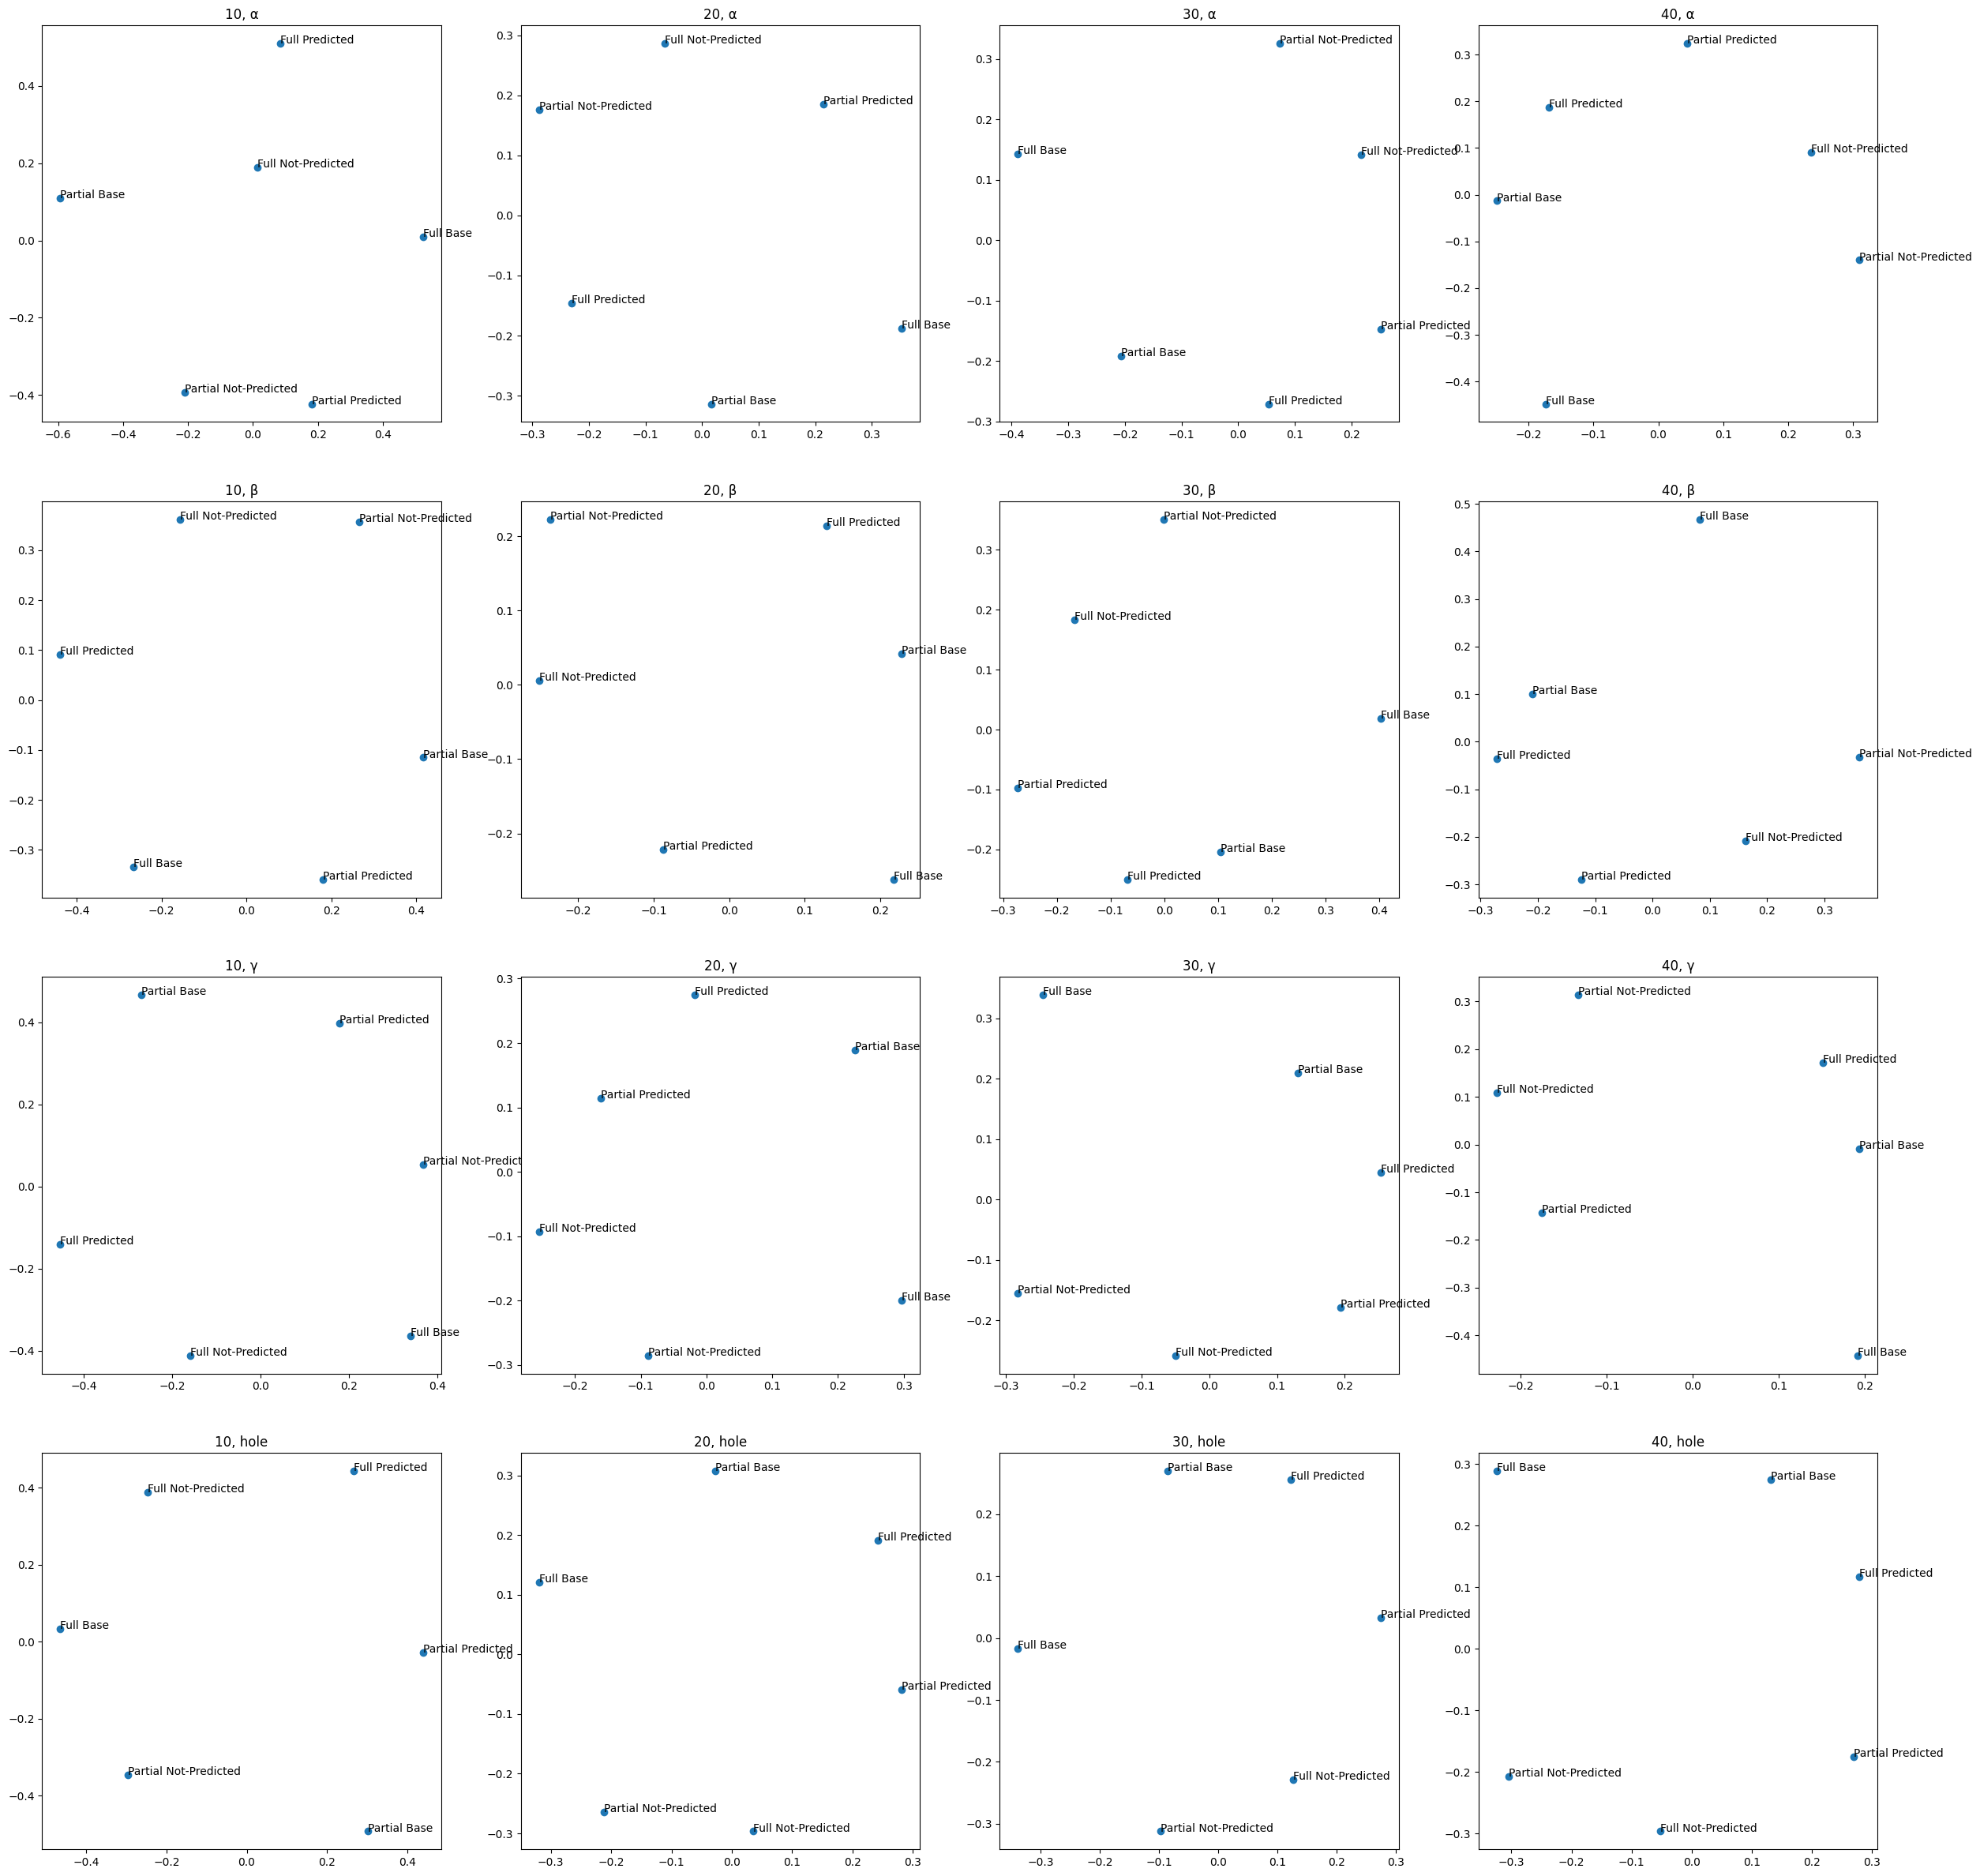

In [26]:
_, axes = plt.subplots(4, 4, figsize=(30, 30))
for x, free_axis in enumerate(invariances_frame['Free Axis'].unique()):
    for y, n_fully_seen in enumerate([10, 20, 30, 40]):
        pts = embedding.fit_transform(1 - dist_mats[(dist_mats['Instances Fully Seen'] == n_fully_seen) & (dist_mats['Free Axis'] == free_axis)].iloc[0]['Distance Matrix'])
        axes[x, y].scatter(pts[:, 0], pts[:, 1])
        for t, xy in ((['Full Base', 'Partial Base', 'Full Predicted', 'Full Not-Predicted', 'Partial Predicted', 'Partial Not-Predicted'][i], tuple(pts[i])) for i in range(6)):
            axes[x][y].annotate(t, xy)
        axes[x, y].set_title(f'{n_fully_seen}, {free_axis}')